In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import os
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader.tiingo import TiingoDailyReader
import pickle
import requests
from collections import Counter

from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from talib import RSI

from fbprophet import Prophet

import boto3

# Load in Data

In [2]:
client = boto3.client('s3')

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [3]:
amzn_obj = client.get_object(Bucket='tech-stock-data', Key='AMZN_stock_df.csv')
msft_obj = client.get_object(Bucket='tech-stock-data', Key='MSFT_stock_df.csv')
fb_obj = client.get_object(Bucket='tech-stock-data', Key='FB_stock_df.csv')
googl_obj = client.get_object(Bucket='tech-stock-data', Key='GOOGL_stock_df.csv')
aapl_obj = client.get_object(Bucket='tech-stock-data', Key='AAPL_stock_df.csv')

amzn_df = pd.read_csv(amzn_obj['Body'])
msft_df = pd.read_csv(msft_obj['Body'])
fb_df = pd.read_csv(fb_obj['Body'])
googl_df = pd.read_csv(googl_obj['Body'])
aapl_df = pd.read_csv(aapl_obj['Body'])

In [4]:
amzn_df['date'] = pd.to_datetime(amzn_df["date"]).dt.date
msft_df['date'] = pd.to_datetime(msft_df["date"]).dt.date
fb_df['date'] = pd.to_datetime(fb_df["date"]).dt.date
googl_df['date'] = pd.to_datetime(googl_df["date"]).dt.date
aapl_df['date'] = pd.to_datetime(aapl_df["date"]).dt.date

In [5]:
with open('amzn.pickle', 'wb') as to_write:
    pickle.dump(amzn_df, to_write)

In [6]:
with open('msft.pickle', 'wb') as to_write:
    pickle.dump(msft_df, to_write)

In [7]:
with open('fb.pickle', 'wb') as to_write:
    pickle.dump(fb_df, to_write)

In [8]:
with open('googl.pickle', 'wb') as to_write:
    pickle.dump(googl_df, to_write)

In [9]:
with open('aapl.pickle', 'wb') as to_write:
    pickle.dump(aapl_df, to_write)

# EDA

In [10]:
with open('amzn.pickle','rb') as read_file:
    amzn_df = pickle.load(read_file)

In [11]:
with open('msft.pickle','rb') as read_file:
    msft_df = pickle.load(read_file)

In [12]:
with open('fb.pickle','rb') as read_file:
    fb_df = pickle.load(read_file)

In [13]:
with open('googl.pickle','rb') as read_file:
    googl_df = pickle.load(read_file)

In [14]:
with open('aapl.pickle','rb') as read_file:
    aapl_df = pickle.load(read_file)

In [15]:
amzn_df.head(5)

,symbol,date,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
0,AMZN,2015-01-02,308.52,314.75,306.9601,312.58,2788101,308.52,0.0,314.75,306.9601,312.58,1.0,2788101
1,AMZN,2015-01-05,302.19,308.38,300.8500,307.01,2774231,302.19,0.0,308.38,300.8500,307.01,1.0,2774231
2,AMZN,2015-01-06,295.29,303.00,292.3800,302.24,3519034,295.29,0.0,303.00,292.3800,302.24,1.0,3519034
3,AMZN,2015-01-07,298.42,301.28,295.3300,297.50,2640349,298.42,0.0,301.28,295.3300,297.50,1.0,2640349
4,AMZN,2015-01-08,300.46,303.14,296.1100,300.32,3088398,300.46,0.0,303.14,296.1100,300.32,1.0,3088398


In [16]:
amzn_df.describe()

,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
count,1174.000000,1174.000000,1174.000000,1174.000000,1.174000e+03,1174.000000,1174.0,1174.000000,1174.000000,1174.000000,1174.0,1.174000e+03
mean,1067.677500,1078.044094,1056.289843,1068.145843,4.256362e+06,1067.677500,0.0,1078.044094,1056.289843,1068.145843,1.0,4.256362e+06
std,519.121222,524.614944,513.240538,519.785295,2.275208e+06,519.121222,0.0,524.614944,513.240538,519.785295,0.0,2.275208e+06
min,286.950000,290.790000,285.250000,286.280000,1.092970e+06,286.950000,0.0,290.790000,285.250000,286.280000,1.0,1.092970e+06
25%,640.350000,650.805000,627.862500,642.940000,2.781294e+06,640.350000,0.0,650.805000,627.862500,642.940000,1.0,2.781294e+06
50%,938.065000,947.315000,929.050000,940.735000,3.665846e+06,938.065000,0.0,947.315000,929.050000,940.735000,1.0,3.665846e+06
75%,1603.030000,1623.350000,1590.832500,1604.000000,4.935907e+06,1603.030000,0.0,1623.350000,1590.832500,1604.000000,1.0,4.935907e+06
max,2039.510000,2050.500000,2013.000000,2038.110000,2.385606e+07,2039.510000,0.0,2050.500000,2013.000000,2038.110000,1.0,2.385606e+07


In [17]:
msft_df.describe()

,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
count,1174.000000,1174.000000,1174.000000,1174.000000,1.174000e+03,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.0,1.174000e+03
mean,73.818700,74.417024,73.139472,73.802625,2.945016e+07,76.504902,0.006346,77.124854,75.801317,76.487362,1.0,2.945016e+07
std,29.096152,29.347064,28.809133,29.122410,1.419145e+07,28.019023,0.049892,28.261208,27.742052,28.047027,0.0,1.419145e+07
min,36.394867,36.962229,36.241721,36.566031,7.425503e+06,40.290000,0.000000,40.740000,39.720000,40.340000,1.0,7.425503e+06
25%,49.003563,49.414156,48.560062,48.835930,2.082264e+07,52.642500,0.000000,53.017500,52.100000,52.547500,1.0,2.082264e+07
50%,65.350319,65.576431,64.799815,65.241024,2.625888e+07,68.220000,0.000000,68.490000,67.590000,68.145000,1.0,2.625888e+07
75%,99.241016,100.013251,98.049965,99.172412,3.368822e+07,101.102500,0.000000,101.832500,99.598750,101.137500,1.0,3.368822e+07
max,140.856391,141.190245,139.819949,141.015843,1.691640e+08,141.340000,0.460000,141.675000,140.300000,141.500000,1.0,1.691640e+08


In [18]:
aapl_df.head(5)

,symbol,date,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
0,AAPL,2015-01-02,100.745479,102.689804,98.920948,102.643730,53204626,109.33,0.0,111.44,107.350,111.39,1.0,53204626
1,AAPL,2015-01-05,97.907319,100.118873,97.133275,99.787140,64285491,106.25,0.0,108.65,105.410,108.29,1.0,64285491
2,AAPL,2015-01-06,97.916534,98.994666,96.414520,98.174548,65797116,106.26,0.0,107.43,104.630,106.54,1.0,65797116
3,AAPL,2015-01-07,99.289540,99.704206,98.317378,98.782726,40105934,107.75,0.0,108.20,106.695,107.20,1.0,40105934
4,AAPL,2015-01-08,103.104470,103.344055,100.164947,100.653331,59364547,111.89,0.0,112.15,108.700,109.23,1.0,59364547


In [19]:
stocks_df = pd.DataFrame({"Date": amzn_df["date"],
                      "FB": fb_df["adjClose"],
                      "AMZN": amzn_df["adjClose"],
                      "MSFT": msft_df["adjClose"],
                      "GOOGL": googl_df["adjClose"],
                      "AAPL": aapl_df["adjClose"],
                      "FB_volume": fb_df["volume"],
                      "AMZN_volume": amzn_df["volume"],
                      "MSFT_volume": msft_df["volume"],
                      "GOOGL_volume": googl_df["volume"],
                      "AAPL_volume": aapl_df["volume"]                          
                         })
stocks_df = stocks_df.set_index("Date")

stocks_df.head(5)

,FB,AMZN,MSFT,GOOGL,AAPL,FB_volume,AMZN_volume,MSFT_volume,GOOGL_volume,AAPL_volume
Date,,,,,,,,,,
2015-01-02,78.450,308.52,42.124356,529.55,100.745479,18177475,2788101,27913852,1327870,53204626
2015-01-05,77.190,302.19,41.732481,519.46,97.907319,26452191,2774231,39673865,2059119,64285491
2015-01-06,76.150,295.29,41.124399,506.64,97.916534,27399288,3519034,36447854,2731813,65797116
2015-01-07,76.150,298.42,41.646899,505.15,99.289540,22045333,2640349,29114061,2345875,40105934
2015-01-08,78.175,300.46,42.872073,506.91,103.104470,23960953,3088398,29645202,3662224,59364547


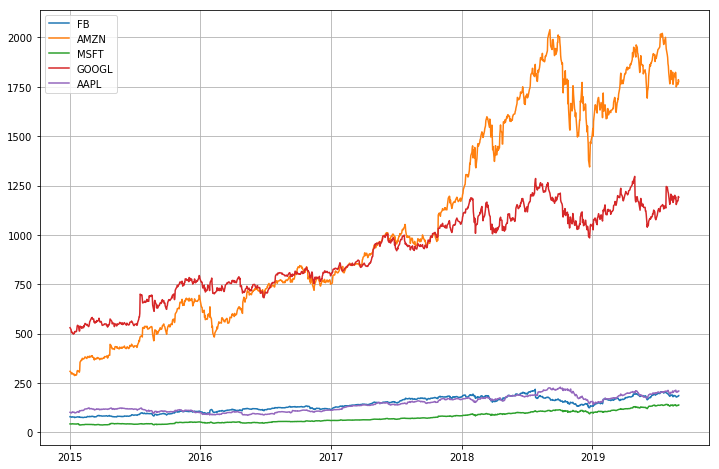

In [20]:
plt.figure(figsize=(12,8))
plt.plot(stocks_df.index, stocks_df["FB"], label="FB")
plt.plot(stocks_df.index, stocks_df["AMZN"], label="AMZN")
plt.plot(stocks_df.index, stocks_df["MSFT"], label="MSFT")
plt.plot(stocks_df.index, stocks_df["GOOGL"], label="GOOGL")
plt.plot(stocks_df.index, stocks_df["AAPL"], label="AAPL")
plt.legend()
plt.grid()

## Growth of a Stock (in logs)

The advantage of using log differences is that this difference can be interpreted as the percentage change in a stock but does not depend on the denominator of a fraction.

In [21]:
stock_log_change_df = stocks_df.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_log_change_df = stock_log_change_df.iloc[1:]
stock_log_change_df.head(5)

,FB,AMZN,MSFT,GOOGL,AAPL,FB_volume,AMZN_volume,MSFT_volume,GOOGL_volume,AAPL_volume
Date,,,,,,,,,,
2015-01-05,-0.016192,-0.020731,-0.009346,-0.019238,-0.028576,0.375156,-0.004987,0.351570,0.438702,0.189189
2015-01-06,-0.013565,-0.023098,-0.014678,-0.024989,0.000094,0.035178,0.237813,-0.084810,0.282687,0.023242
2015-01-07,0.000000,0.010544,0.012625,-0.002945,0.013925,-0.217416,-0.287275,-0.224661,-0.152307,-0.495052
2015-01-08,0.026245,0.006813,0.028994,0.003478,0.037703,0.083325,0.156741,0.018079,0.445412,0.392173
2015-01-09,-0.005580,-0.011818,-0.008441,-0.012286,0.001072,-0.131707,-0.183378,-0.223165,-0.572745,-0.107478


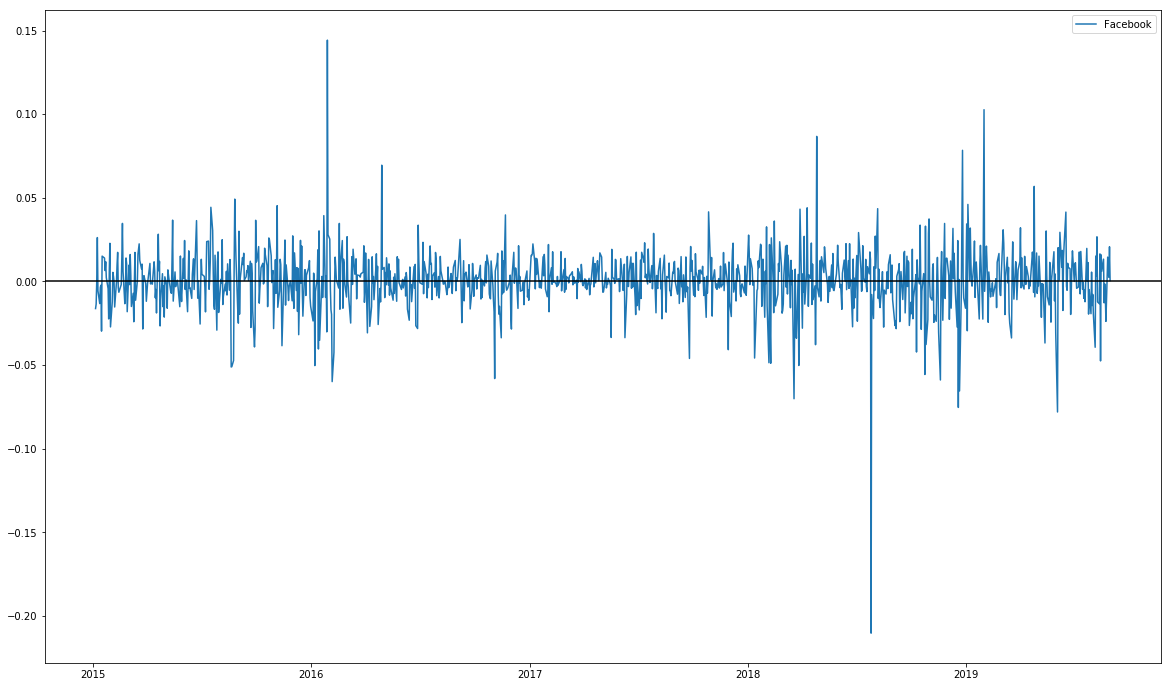

In [22]:
plt.figure(figsize=(20,12))
plt.plot(stock_log_change_df.index, stock_log_change_df["FB"], label="Facebook")
plt.axhline(y=0, color='black', linestyle='-')
plt.legend()

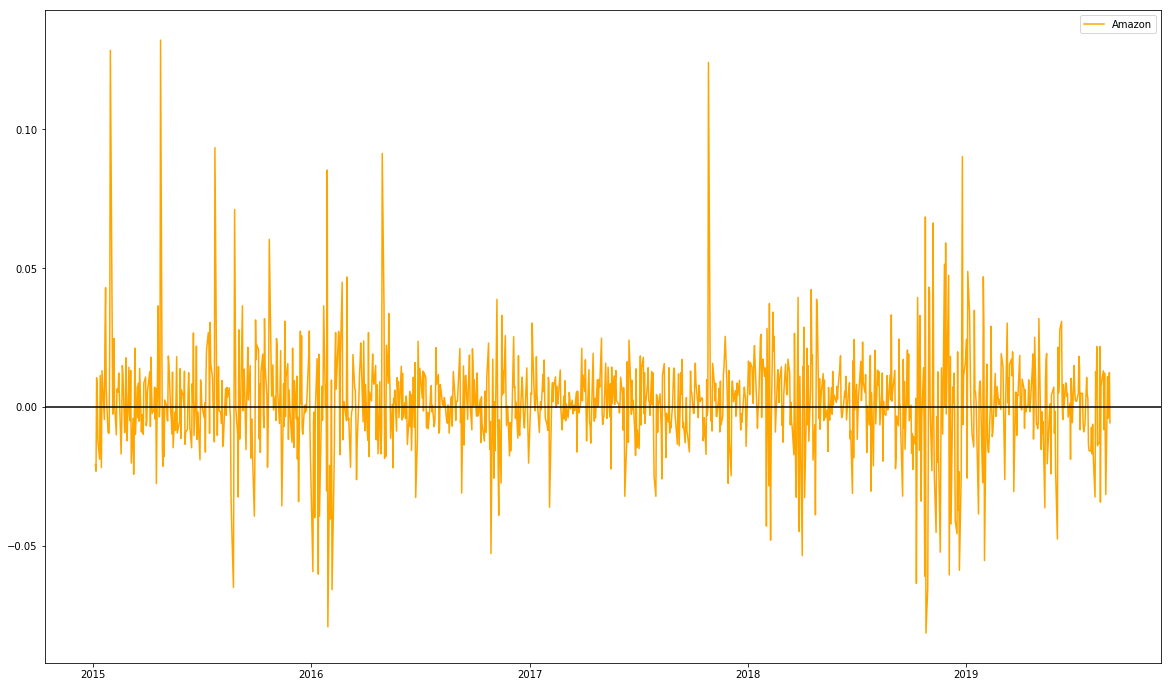

In [23]:
plt.figure(figsize=(20,12))
plt.plot(stock_log_change_df.index, stock_log_change_df["AMZN"], label="Amazon", color="orange")
plt.axhline(y=0, color='black', linestyle='-')
plt.legend()

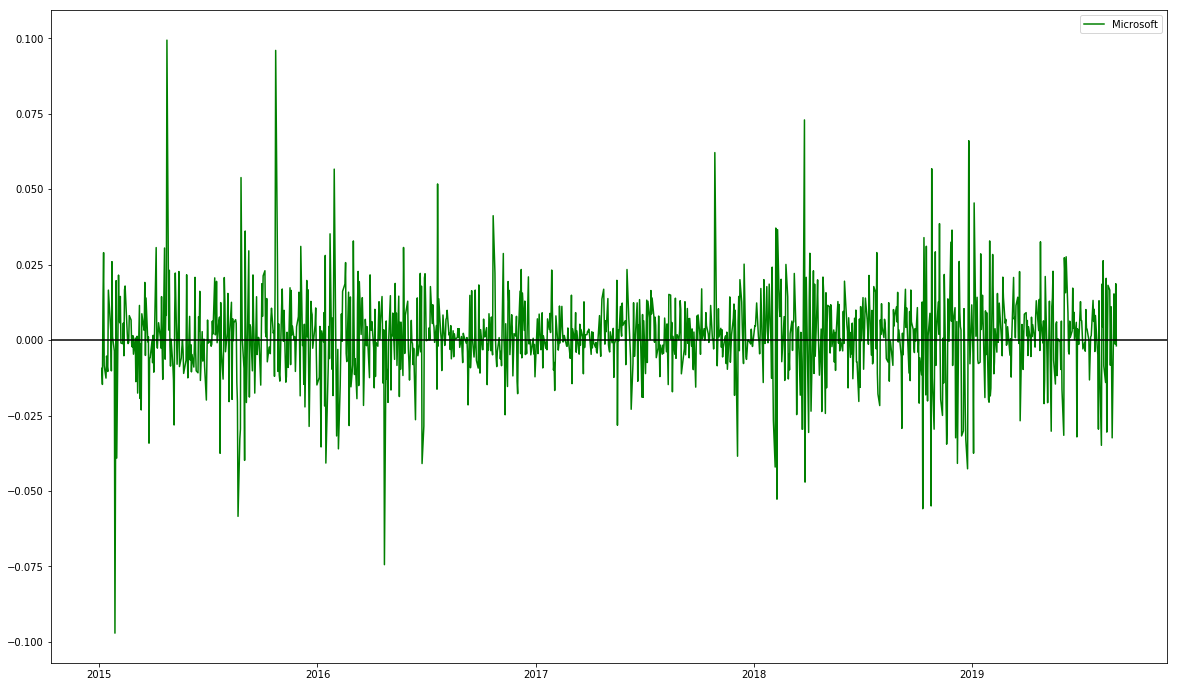

In [24]:
plt.figure(figsize=(20,12))
plt.plot(stock_log_change_df.index, stock_log_change_df["MSFT"], label="Microsoft", color="green")
plt.axhline(y=0, color='black', linestyle='-')
plt.legend()

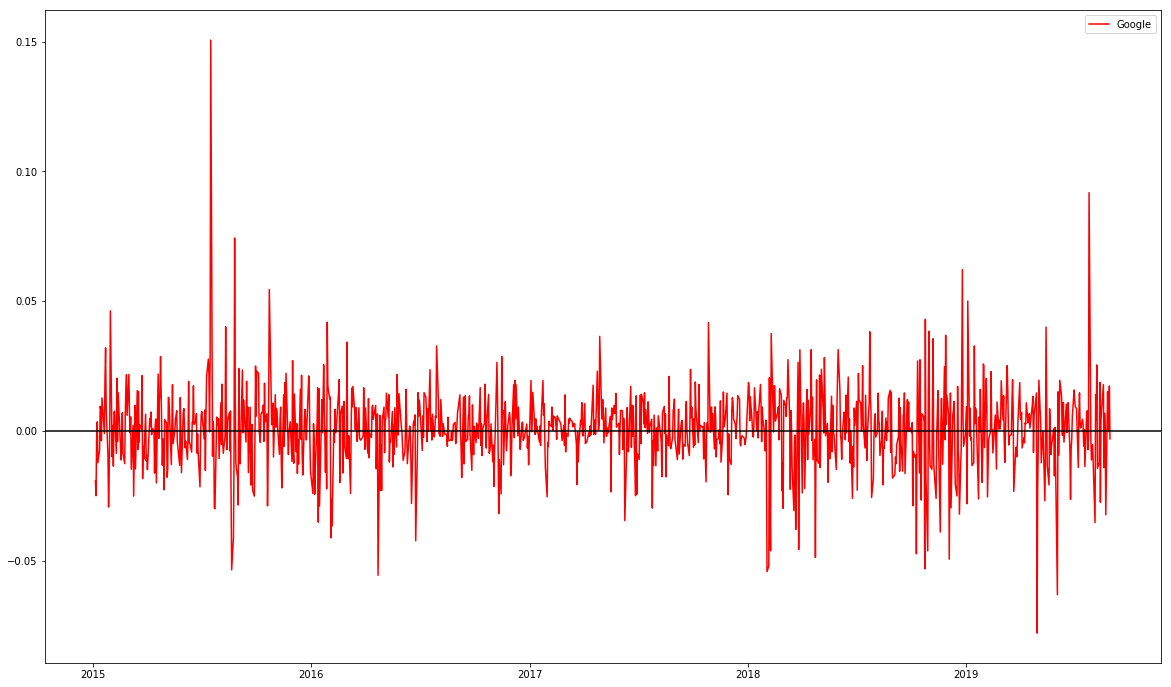

In [25]:
plt.figure(figsize=(20,12))
plt.plot(stock_log_change_df.index, stock_log_change_df["GOOGL"], label="Google", color="red")
plt.axhline(y=0, color='black', linestyle='-')
plt.legend()

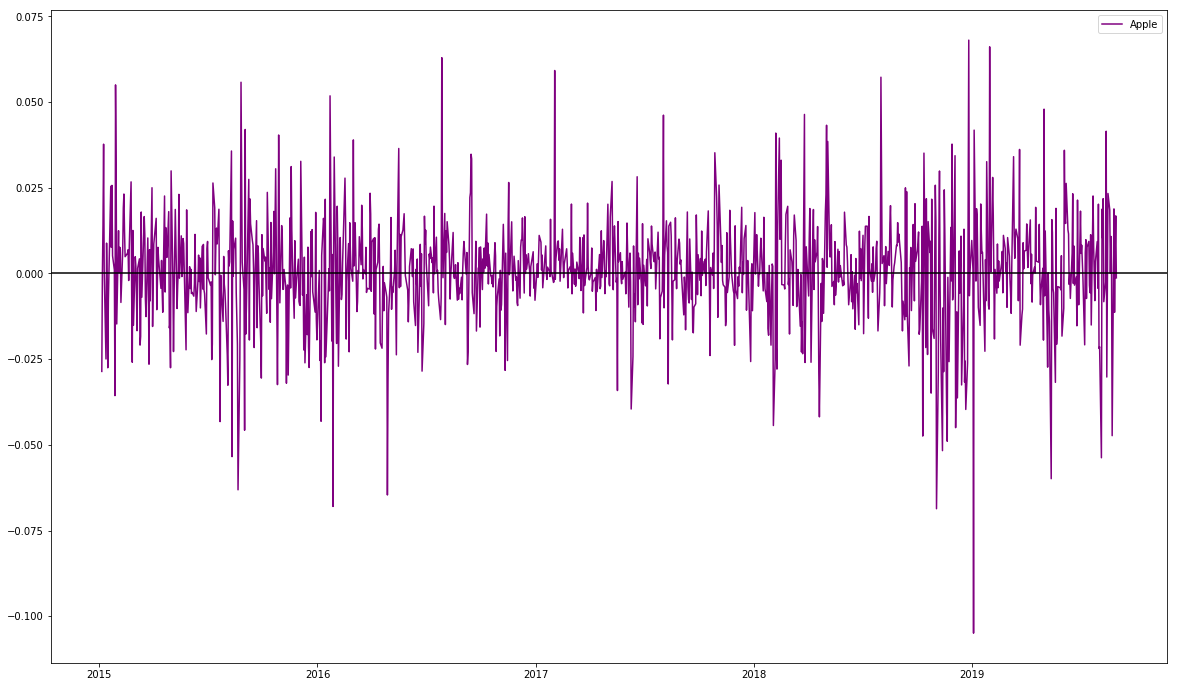

In [26]:
plt.figure(figsize=(20,12))
plt.plot(stock_log_change_df.index, stock_log_change_df["AAPL"], label="Apple", color="purple")
plt.axhline(y=0, color='black', linestyle='-')
plt.legend()

## Trend Trading

https://www.investopedia.com/articles/active-trading/041814/four-most-commonlyused-indicators-trend-trading.asp

Trend traders attempt to isolate and extract profit from trends. There are multiple ways to do this. Of course, no single indicator will punch your ticket to market riches, as trading involves factors such as risk management and trading psychology as well. But certain indicators have stood the test of time and remain popular among trend traders.

### Moving Averages

You will notice that a moving average is much smoother than the actual stock data. Additionally, it’s a stubborn indicator; a stock needs to be above or below the moving average line in order for the line to change direction. Thus, crossing a moving average signals a possible change in trend, and should draw attention.

Crossovers are another way to utilize moving averages. By plotting a 200-day and 50-day moving average on your chart, a buy signal occurs when the 50-day crosses above the 200-day. A sell signal occurs when the 50-day drops below the 200-day. 

When the price crosses above a moving average, it can also be used as a buy signal, and when the price crosses below a moving average, it can be used as a sell signal. Since price is more volatile than the moving average, this method is prone to more false signals, as the chart above shows.

Moving averages can also provide support or resistance to the price. The chart below shows a 100-day moving average acting as support (i.e., price bounces off of it).

As a general guideline, if the price is above a moving average, the trend is up. If the price is below a moving average, the trend is down. However, moving averages can have different lengths (discussed shortly), so one MA may indicate an uptrend while another MA indicates a downtrend.



The 20-day may be of analytical benefit to a shorter-term trader since it follows the price more closely and therefore produces less "lag" than the longer-term moving average. A 100-day MA may be more beneficial to a longer-term trader.



Moving averages don't predict though; they simply show what the price is doing, on average, over a period of time.

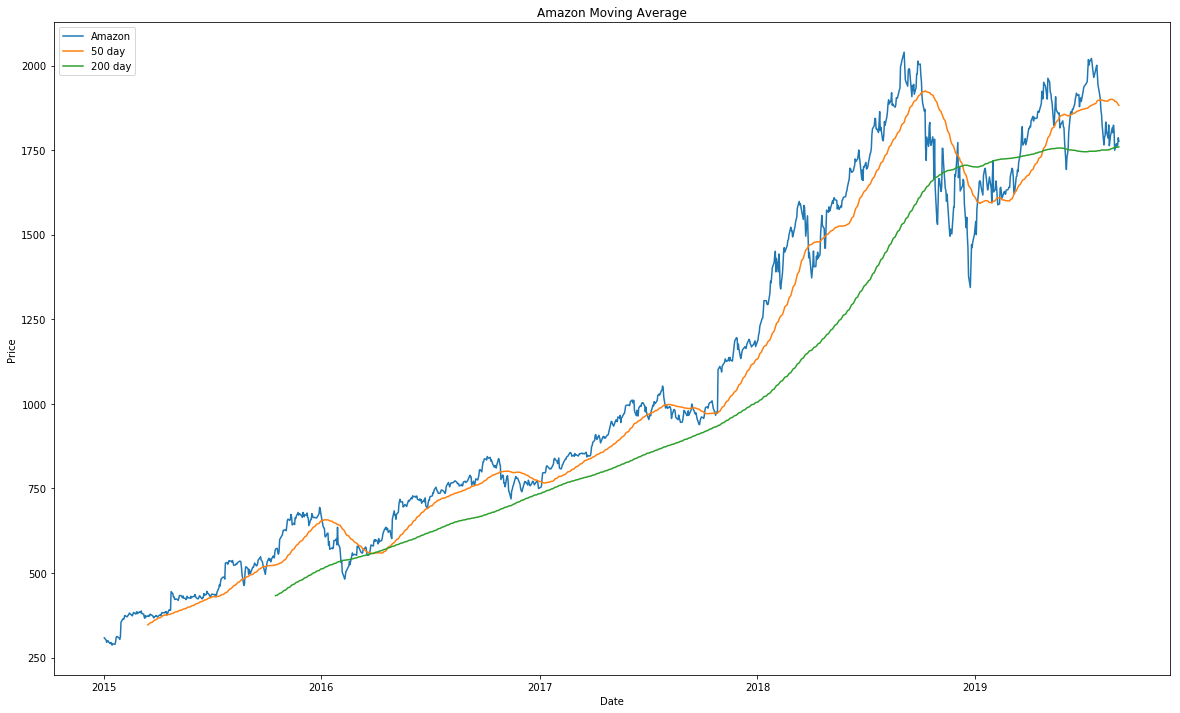

In [27]:
plt.figure(figsize=(20,12))

#stocks_df["AMZN_20d"] = np.round(stocks_df["AMZN"].rolling(window = 20, center = False).mean(), 2)
stocks_df["AMZN_50d"] = np.round(stocks_df["AMZN"].rolling(window = 50, center = False).mean(), 2)
stocks_df["AMZN_200d"] = np.round(stocks_df["AMZN"].rolling(window = 200, center = False).mean(), 2)

plt.plot(stocks_df.index, stocks_df["AMZN"], label="Amazon")
#plt.plot(stocks_df.index, stocks_df["AMZN_20d"], label="20 day")
plt.plot(stocks_df.index, stocks_df["AMZN_50d"], label="50 day")
plt.plot(stocks_df.index, stocks_df["AMZN_200d"], label="200 day")
plt.title("Amazon Moving Average")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

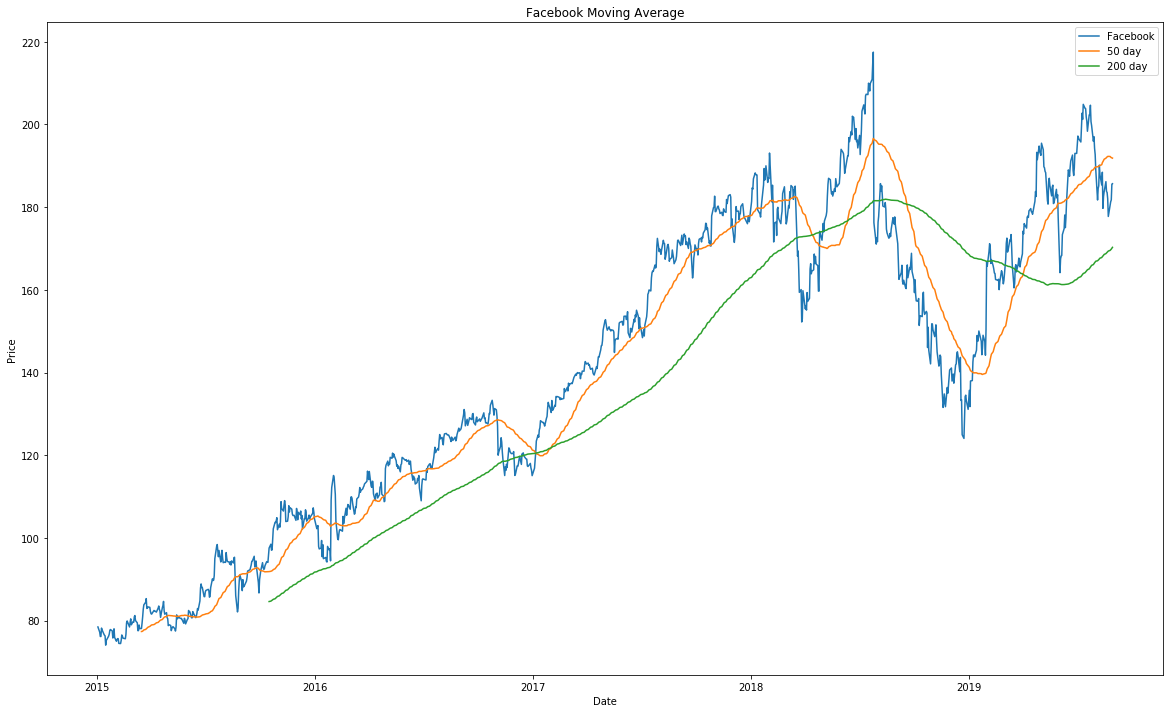

In [28]:
plt.figure(figsize=(20,12))

#stocks_df["FB_20d"] = np.round(stocks_df["FB"].rolling(window = 20, center = False).mean(), 2)
stocks_df["FB_50d"] = np.round(stocks_df["FB"].rolling(window = 50, center = False).mean(), 2)
stocks_df["FB_200d"] = np.round(stocks_df["FB"].rolling(window = 200, center = False).mean(), 2)

plt.plot(stocks_df.index, stocks_df["FB"], label="Facebook")
#plt.plot(stocks_df.index, stocks_df["FB_20d"], label="20 day")
plt.plot(stocks_df.index, stocks_df["FB_50d"], label="50 day")
plt.plot(stocks_df.index, stocks_df["FB_200d"], label="200 day")
plt.title("Facebook Moving Average")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

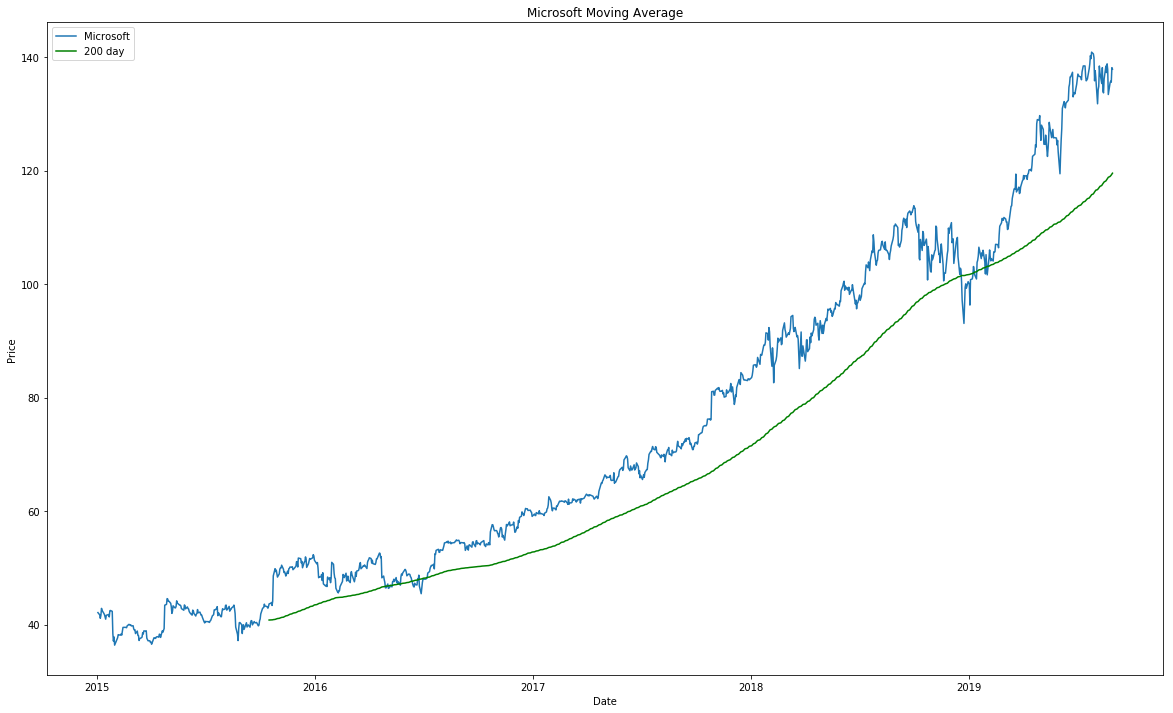

In [46]:
plt.figure(figsize=(20,12))

#stocks_df["MSFT_20d"] = np.round(stocks_df["MSFT"].rolling(window = 20, center = False).mean(), 2)
stocks_df["MSFT_50d"] = np.round(stocks_df["MSFT"].rolling(window = 50, center = False).mean(), 2)
stocks_df["MSFT_200d"] = np.round(stocks_df["MSFT"].rolling(window = 200, center = False).mean(), 2)

plt.plot(stocks_df.index, stocks_df["MSFT"], label="Microsoft")
#plt.plot(stocks_df.index, stocks_df["MSFT_20d"], label="20 day")
#plt.plot(stocks_df.index, stocks_df["MSFT_50d"], label="50 day")
plt.plot(stocks_df.index, stocks_df["MSFT_200d"], label="200 day", color="green")
plt.title("Microsoft Moving Average")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

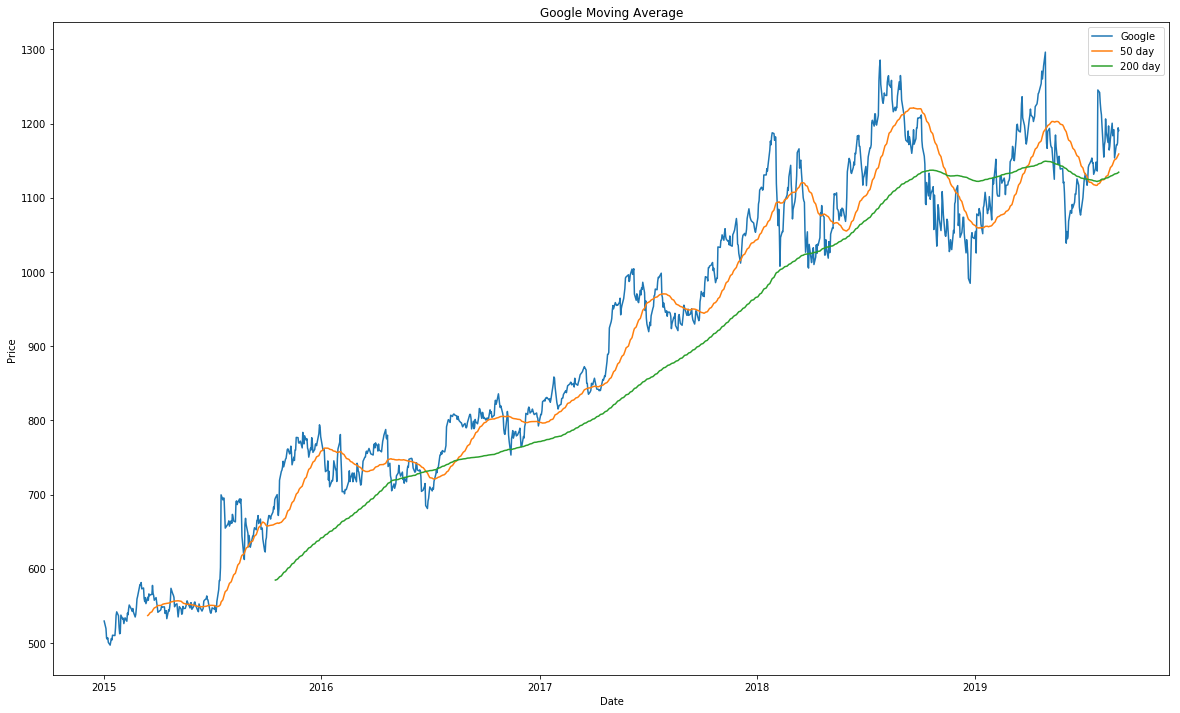

In [30]:
plt.figure(figsize=(20,12))

#stocks_df["GOOGL_20d"] = np.round(stocks_df["GOOGL"].rolling(window = 20, center = False).mean(), 2)
stocks_df["GOOGL_50d"] = np.round(stocks_df["GOOGL"].rolling(window = 50, center = False).mean(), 2)
stocks_df["GOOGL_200d"] = np.round(stocks_df["GOOGL"].rolling(window = 200, center = False).mean(), 2)

plt.plot(stocks_df.index, stocks_df["GOOGL"], label="Google")
#plt.plot(stocks_df.index, stocks_df["GOOGL_20d"], label="20 day")
plt.plot(stocks_df.index, stocks_df["GOOGL_50d"], label="50 day")
plt.plot(stocks_df.index, stocks_df["GOOGL_200d"], label="200 day")
plt.title("Google Moving Average")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

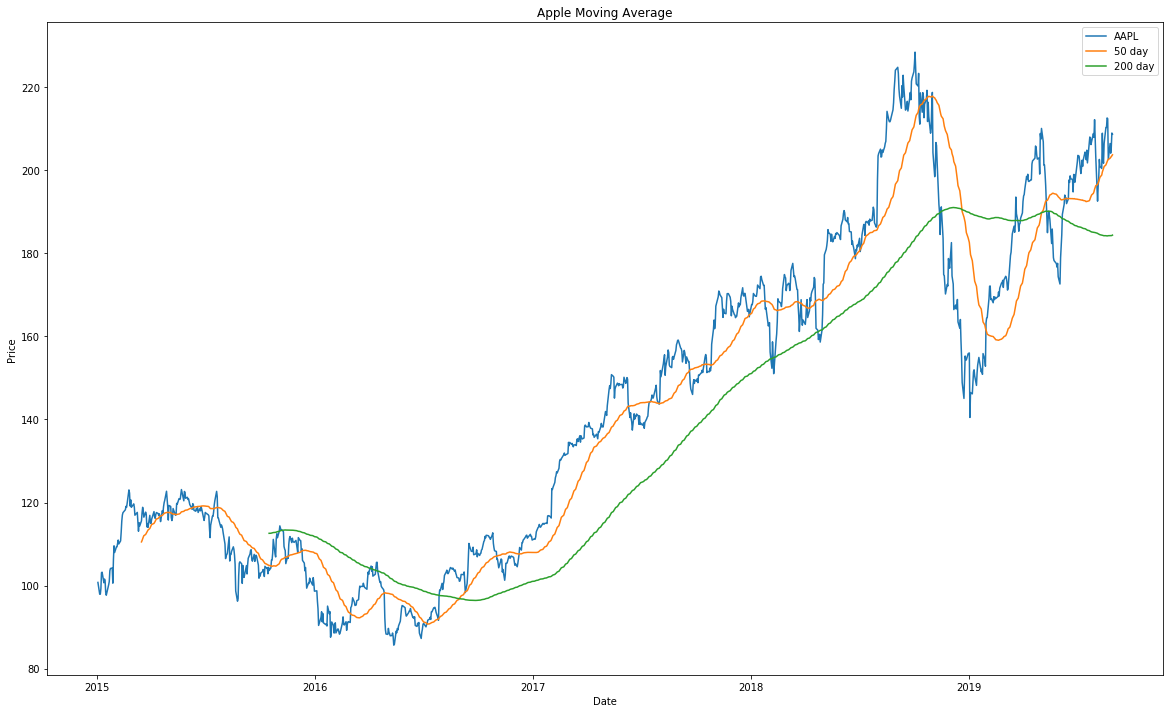

In [31]:
plt.figure(figsize=(20,12))

#stocks_df["AAPL_20d"] = np.round(stocks_df["AAPL"].rolling(window = 20, center = False).mean(), 2)
stocks_df["AAPL_50d"] = np.round(stocks_df["AAPL"].rolling(window = 50, center = False).mean(), 2)
stocks_df["AAPL_200d"] = np.round(stocks_df["AAPL"].rolling(window = 200, center = False).mean(), 2)

plt.plot(stocks_df.index, stocks_df["AAPL"], label="AAPL")
#plt.plot(stocks_df.index, stocks_df["AAPL_20d"], label="20 day")
plt.plot(stocks_df.index, stocks_df["AAPL_50d"], label="50 day")
plt.plot(stocks_df.index, stocks_df["AAPL_200d"], label="200 day")
plt.title("Apple Moving Average")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

### Exponential Moving Averages

The simple moving average (SMA) is the average price of a security over a specific period. For instance, the 50-day moving average is calculated by taking the last 50 day sum of closing prices and dividing by 50. The average is re-calculated as new data comes in, creating a “moving average.”

The exponential moving average (EMA) provides more weight to the most recent prices in an attempt to better reflect new market data.

The difference between the two is noticeable when comparing long-term averages.

The 200-day EMA is quicker to react to the most recent price changes in indexes such as the S&P 500, which is not surprising since the exponential moving average has a smaller lag time, or more responsive, compared to the the simple moving average.

Moving average preferences typically depends on an investors time horizons and objectives. We like to use the 200-day EMA to identify strong long-term trends and momentum in an investment. The 200-day EMA helps us determine when we are in or out of an investment.

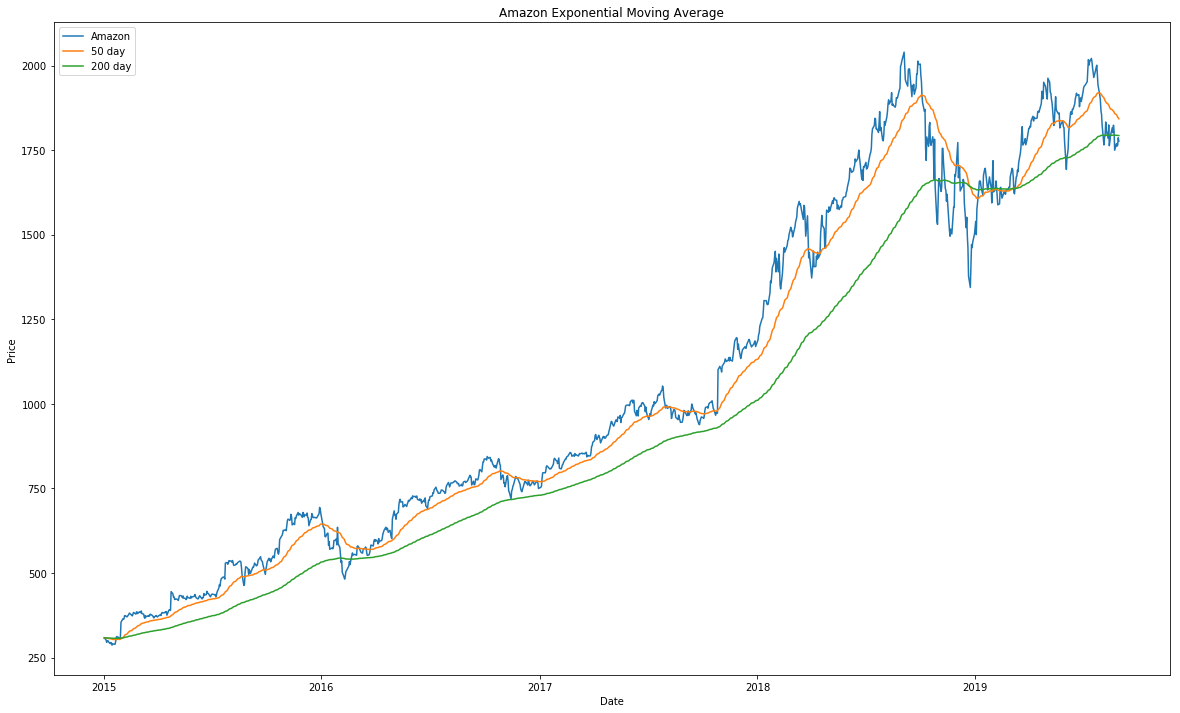

In [32]:
plt.figure(figsize=(20,12))

#stocks_df["AMZN_exp_20d"] = np.round(stocks_df["AMZN"].ewm(span = 20, adjust = False).mean(), 2)
stocks_df["AMZN_exp_50d"] = np.round(stocks_df["AMZN"].ewm(span = 50, adjust = False).mean(), 2)
stocks_df["AMZN_exp_200d"] = np.round(stocks_df["AMZN"].ewm(span = 200, adjust = False).mean(), 2)

plt.plot(stocks_df.index, stocks_df["AMZN"], label="Amazon")
#plt.plot(stocks_df.index, stocks_df["AMZN_20d"], label="20 day")
plt.plot(stocks_df.index, stocks_df["AMZN_exp_50d"], label="50 day")
plt.plot(stocks_df.index, stocks_df["AMZN_exp_200d"], label="200 day")
plt.title("Amazon Exponential Moving Average")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

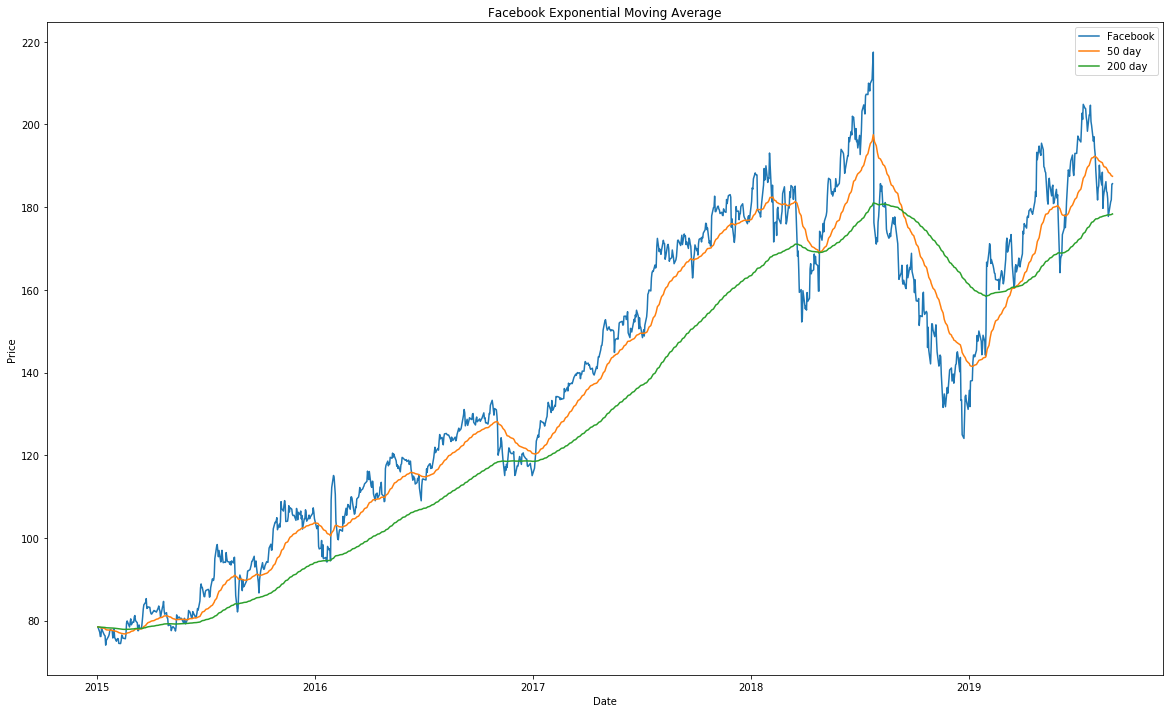

In [33]:
plt.figure(figsize=(20,12))

#stocks_df["FB_exp_20d"] = np.round(stocks_df["FB"].ewm(span = 20, adjust = False).mean(), 2)
stocks_df["FB_exp_50d"] = np.round(stocks_df["FB"].ewm(span = 50, adjust = False).mean(), 2)
stocks_df["FB_exp_200d"] = np.round(stocks_df["FB"].ewm(span = 200, adjust = False).mean(), 2)

plt.plot(stocks_df.index, stocks_df["FB"], label="Facebook")
#plt.plot(stocks_df.index, stocks_df["FB_20d"], label="20 day")
plt.plot(stocks_df.index, stocks_df["FB_exp_50d"], label="50 day")
plt.plot(stocks_df.index, stocks_df["FB_exp_200d"], label="200 day")
plt.title("Facebook Exponential Moving Average")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

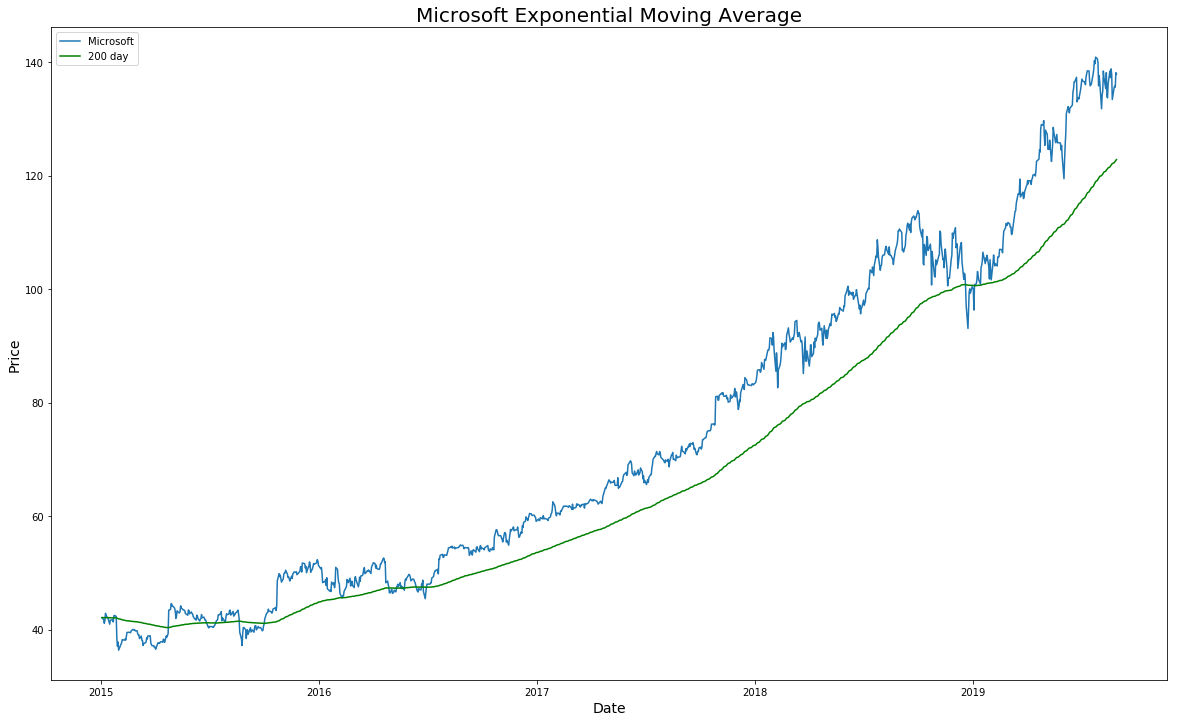

In [50]:
plt.figure(figsize=(20,12))

#stocks_df["MSFT_exp_20d"] = np.round(stocks_df["MSFT"].ewm(span = 20, adjust = False).mean(), 2)
stocks_df["MSFT_exp_50d"] = np.round(stocks_df["MSFT"].ewm(span = 50, adjust = False).mean(), 2)
stocks_df["MSFT_exp_200d"] = np.round(stocks_df["MSFT"].ewm(span = 200, adjust = False).mean(), 2)

plt.plot(stocks_df.index, stocks_df["MSFT"], label="Microsoft")
#plt.plot(stocks_df.index, stocks_df["MSFT_20d"], label="20 day")
#plt.plot(stocks_df.index, stocks_df["MSFT_exp_50d"], label="50 day")
plt.plot(stocks_df.index, stocks_df["MSFT_exp_200d"], label="200 day", color="green")
plt.title("Microsoft Exponential Moving Average", fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend()

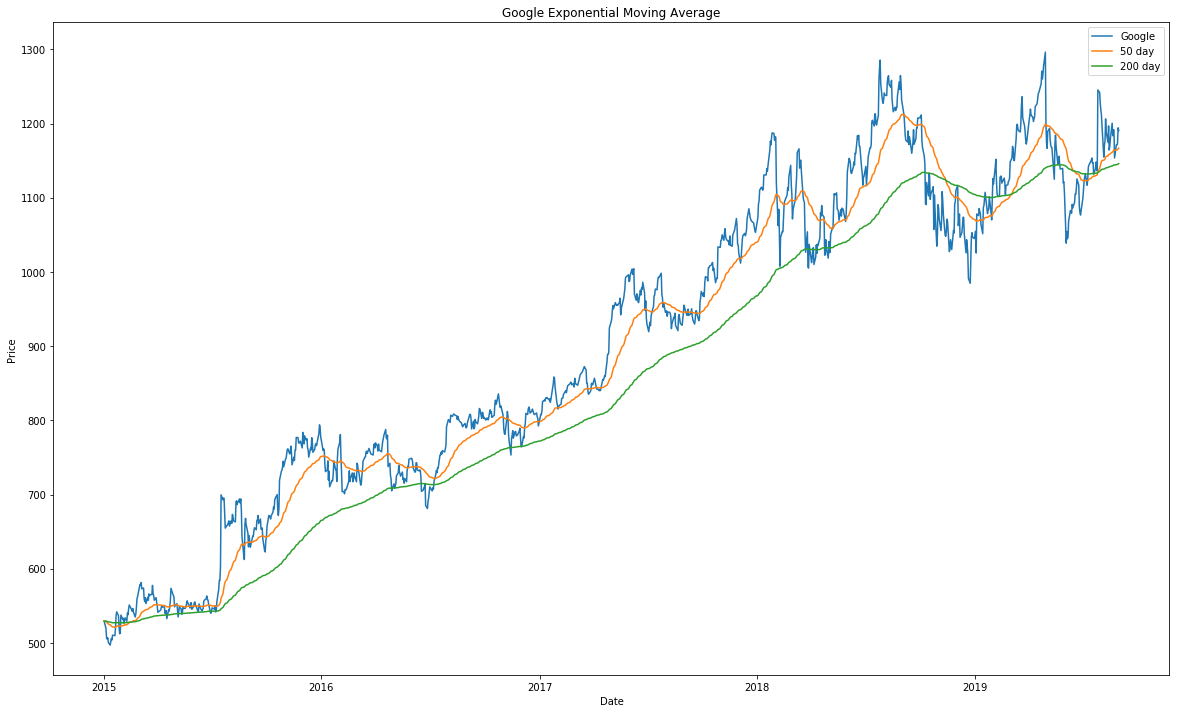

In [35]:
plt.figure(figsize=(20,12))

#stocks_df["GOOGL_exp_20d"] = np.round(stocks_df["GOOGL"].ewm(span = 20, adjust = False).mean(), 2)
stocks_df["GOOGL_exp_50d"] = np.round(stocks_df["GOOGL"].ewm(span = 50, adjust = False).mean(), 2)
stocks_df["GOOGL_exp_200d"] = np.round(stocks_df["GOOGL"].ewm(span = 200, adjust = False).mean(), 2)

plt.plot(stocks_df.index, stocks_df["GOOGL"], label="Google")
#plt.plot(stocks_df.index, stocks_df["GOOGL_20d"], label="20 day")
plt.plot(stocks_df.index, stocks_df["GOOGL_exp_50d"], label="50 day")
plt.plot(stocks_df.index, stocks_df["GOOGL_exp_200d"], label="200 day")
plt.title("Google Exponential Moving Average")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

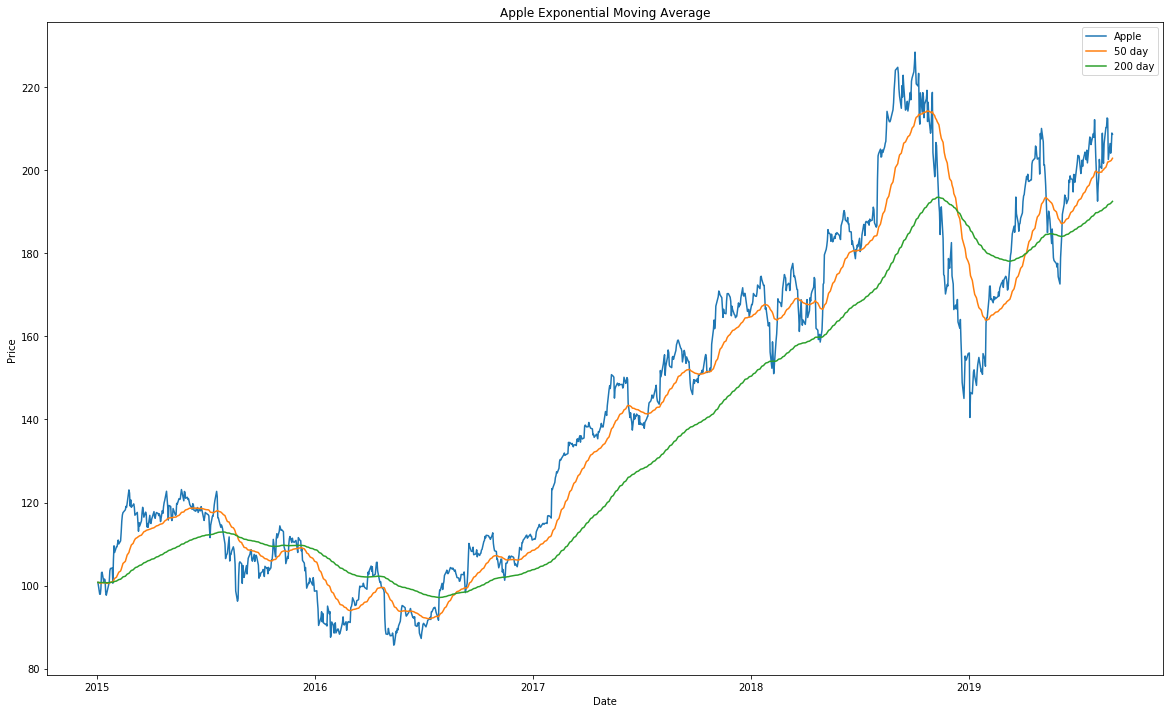

In [36]:
plt.figure(figsize=(20,12))

#stocks_df["AAPL_exp_20d"] = np.round(stocks_df["AAPL"].ewm(span = 20, adjust = False).mean(), 2)
stocks_df["AAPL_exp_50d"] = np.round(stocks_df["AAPL"].ewm(span = 50, adjust = False).mean(), 2)
stocks_df["AAPL_exp_200d"] = np.round(stocks_df["AAPL"].ewm(span = 200, adjust = False).mean(), 2)

plt.plot(stocks_df.index, stocks_df["AAPL"], label="Apple")
#plt.plot(stocks_df.index, stocks_df["GOOGL_20d"], label="20 day")
plt.plot(stocks_df.index, stocks_df["AAPL_exp_50d"], label="50 day")
plt.plot(stocks_df.index, stocks_df["AAPL_exp_200d"], label="200 day")
plt.title("Apple Exponential Moving Average")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

### RSI (Relative Strength Index)

High RSI (usually above 70) may indicate a stock is overbought, therefore it is a sell signal. Low RSI (usually below 30) indicates stock is oversold, which means a buy signal. 

One way to interpret the RSI is by viewing the price as "overbought" – and due for a correction – when the indicator in the histogram is above 70, and viewing the price as oversold – and due for a bounce – when the indicator is below 30. In a strong uptrend, the price will often reach 70 and beyond for sustained periods, and downtrends can stay at 30 or below for a long time. While general overbought and oversold levels can be accurate occasionally, they may not provide the most timely signals for trend traders.

An alternative is to buy near oversold conditions when the trend is up, and place a short trade near an overbought condition in a downtrend.

Say the long-term trend of a stock is up. A buy signal occurs when the RSI moves below 50 and then back above it. Essentially, this means a pullback in price has occurred, and the trader is buying once the pullback appears to have ended (according to the RSI) and the trend is resuming. The 50 level is used because the RSI doesn't typically reach 30 in an uptrend unless a potential reversal is underway. A short-trade signal occurs when the trend is down and the RSI moves above 50 and then back below it.

Trendlines or a moving average can help establish the trend direction and in which direction to take trade signals.

Text(0.5, 1.0, 'Amazon Relative Strength Index')

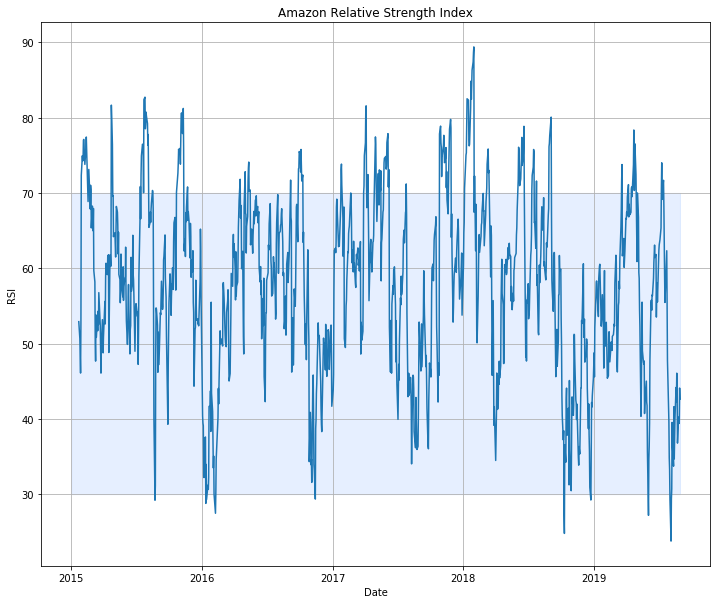

In [37]:
plt.figure(figsize=(12,10))

stocks_df["AMZN_RSI"] = RSI(stocks_df["AMZN"], timeperiod=14)

#plt.plot(stocks_df.index, stocks_df["AMZN"], label="Amazon")
plt.plot(stocks_df.index, stocks_df["AMZN_RSI"], label='RSI')
plt.fill_between(stocks_df.index, y1=30, y2=70, color='#adccff', alpha='0.3')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid()

plt.title("Amazon Relative Strength Index")

Text(0.5, 1.0, 'Facebook Relative Strength Index')

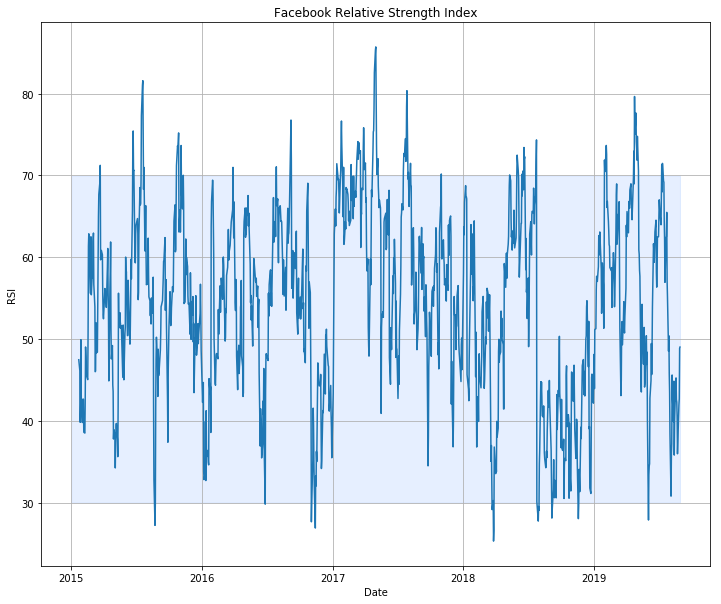

In [38]:
plt.figure(figsize=(12,10))

stocks_df["FB_RSI"] = RSI(stocks_df["FB"], timeperiod=14)

#plt.plot(stocks_df.index, stocks_df["AMZN"], label="Amazon")
plt.plot(stocks_df.index, stocks_df["FB_RSI"], label='RSI')
plt.fill_between(stocks_df.index, y1=30, y2=70, color='#adccff', alpha='0.3')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid()

plt.title("Facebook Relative Strength Index")

Text(0.5, 1.0, 'Microsoft Relative Strength Index')

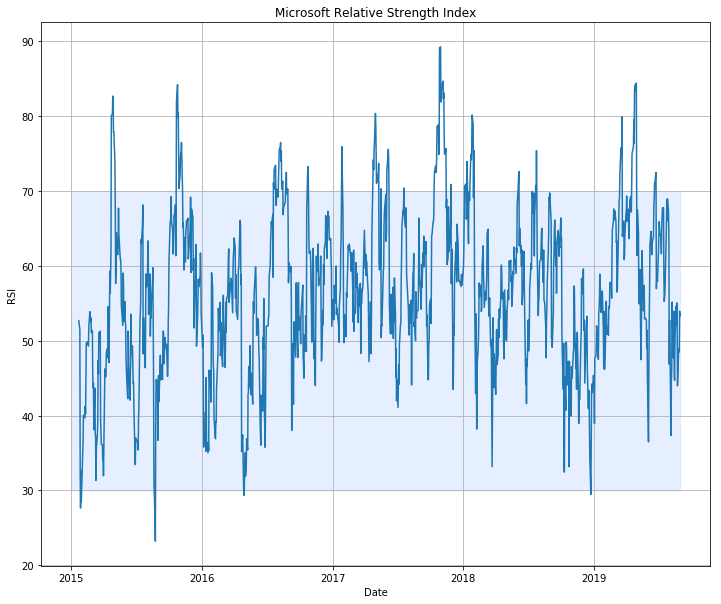

In [39]:
plt.figure(figsize=(12,10))

stocks_df["MSFT_RSI"] = RSI(stocks_df["MSFT"], timeperiod=14)

#plt.plot(stocks_df.index, stocks_df["AMZN"], label="Amazon")
plt.plot(stocks_df.index, stocks_df["MSFT_RSI"], label='RSI')
plt.fill_between(stocks_df.index, y1=30, y2=70, color='#adccff', alpha='0.3')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid()

plt.title("Microsoft Relative Strength Index")

Text(0.5, 1.0, 'Google Relative Strength Index')

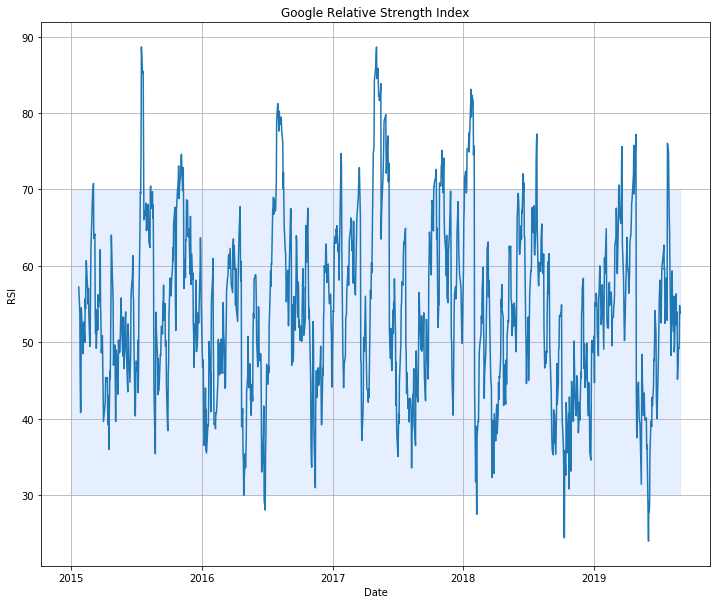

In [40]:
plt.figure(figsize=(12,10))

stocks_df["GOOGL_RSI"] = RSI(stocks_df["GOOGL"], timeperiod=14)

#plt.plot(stocks_df.index, stocks_df["AMZN"], label="Amazon")
plt.plot(stocks_df.index, stocks_df["GOOGL_RSI"], label='RSI')
plt.fill_between(stocks_df.index, y1=30, y2=70, color='#adccff', alpha='0.3')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid()

plt.title("Google Relative Strength Index")

Text(0.5, 1.0, 'Apple Relative Strength Index')

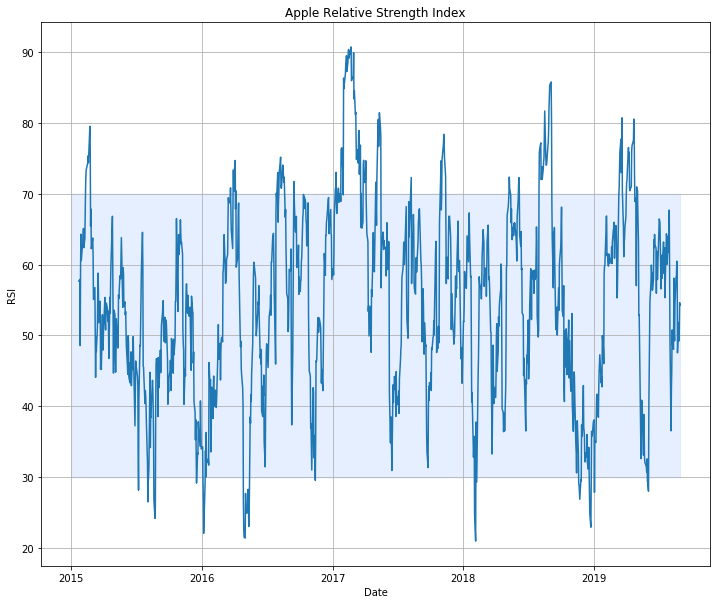

In [41]:
plt.figure(figsize=(12,10))

stocks_df["AAPL_RSI"] = RSI(stocks_df["AAPL"], timeperiod=14)

#plt.plot(stocks_df.index, stocks_df["AMZN"], label="Amazon")
plt.plot(stocks_df.index, stocks_df["AAPL_RSI"], label='RSI')
plt.fill_between(stocks_df.index, y1=30, y2=70, color='#adccff', alpha='0.3')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid()

plt.title("Apple Relative Strength Index")

In [42]:
stocks_df.tail(5)

,FB,AMZN,MSFT,GOOGL,AAPL,FB_volume,AMZN_volume,MSFT_volume,GOOGL_volume,AAPL_volume,...,MSFT_exp_200d,GOOGL_exp_50d,GOOGL_exp_200d,AAPL_exp_50d,AAPL_exp_200d,AMZN_RSI,FB_RSI,MSFT_RSI,GOOGL_RSI,AAPL_RSI
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-26,180.36,1768.87,135.45,1171.18,206.49,8780477,3085320,20325271,1058926,26066130,...,122.24,1164.14,1144.47,202.24,191.96,40.220047,40.368986,48.311842,49.290912,51.828460
2019-08-27,181.30,1761.83,135.74,1170.82,204.16,14408946,3027245,23115635,1173489,25897344,...,122.38,1164.40,1144.73,202.31,192.08,39.376503,41.917656,48.911027,49.209286,49.216148
2019-08-28,181.76,1764.25,135.56,1173.75,205.53,9364533,2411125,17343042,833830,15957632,...,122.51,1164.77,1145.02,202.44,192.22,39.843565,42.701882,48.534944,49.935959,50.786827
2019-08-29,185.57,1786.40,138.12,1194.24,209.01,10135033,3018012,20179716,982098,21007652,...,122.66,1165.92,1145.51,202.70,192.38,44.089468,48.860786,53.957317,54.805610,54.625793
2019-08-30,185.67,1776.29,137.86,1190.53,208.74,10785722,3064147,23946123,903375,21162561,...,122.81,1166.89,1145.96,202.93,192.55,42.611132,49.015688,53.342609,53.785484,54.272057


In [43]:
stocks_df.iloc[14:]

,FB,AMZN,MSFT,GOOGL,AAPL,FB_volume,AMZN_volume,MSFT_volume,GOOGL_volume,AAPL_volume,...,MSFT_exp_200d,GOOGL_exp_50d,GOOGL_exp_200d,AAPL_exp_50d,AAPL_exp_200d,AMZN_RSI,FB_RSI,MSFT_RSI,GOOGL_RSI,AAPL_RSI
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-23,77.830,312.390,42.502719,541.950,104.108884,16746503,4496419,26211594,2298290,46464828,...,42.09,522.59,527.30,100.79,100.74,52.904969,47.465249,52.692308,57.228635,57.671290
2015-01-26,77.495,309.660,42.349572,536.720,104.219462,19260820,3169665,42525530,1546563,55614979,...,42.09,523.14,527.39,100.92,100.78,50.668584,46.105205,51.483908,53.702145,57.899984
2015-01-27,75.780,306.750,38.430818,521.190,100.570398,20109977,2920315,169163953,1957440,95568749,...,42.05,523.07,527.33,100.91,100.78,48.323679,39.815461,31.547322,44.861951,48.573522
2015-01-28,76.240,303.910,37.106549,512.430,106.255934,53306422,3063774,84507078,1791077,146477063,...,42.00,522.65,527.18,101.12,100.83,46.082225,42.097175,27.650622,40.783698,59.515621
2015-01-29,78.000,311.780,37.845257,513.230,109.564049,61293468,8656567,63585273,3950857,84436432,...,41.96,522.28,527.04,101.45,100.92,52.638225,49.920256,32.648256,41.308436,64.278190
2015-01-30,75.910,354.530,36.394867,537.550,107.960673,42649491,23856060,78004944,6055445,83745461,...,41.91,522.88,527.15,101.71,100.99,72.324103,42.565704,28.487429,54.506460,60.559616
2015-02-02,74.990,364.470,37.187627,532.200,109.315250,41955258,10231914,50352532,3768861,62739100,...,41.86,523.24,527.20,102.00,101.07,74.933039,39.786973,33.477746,51.749598,62.531718
2015-02-03,75.400,363.550,37.475903,533.300,109.333679,26957714,6212565,52082448,2353096,51915749,...,41.82,523.64,527.26,102.29,101.15,74.235514,41.616168,35.247267,52.283984,62.559148
2015-02-04,75.630,364.750,37.692110,526.100,110.172227,20277368,4169927,41614812,1694832,70149743,...,41.78,523.74,527.24,102.60,101.24,74.568054,42.668354,36.609217,48.497809,63.855739


In [44]:
with open('stocks_ti.pickle', 'wb') as to_write:
    pickle.dump(stocks_df.iloc[14:], to_write)